# Chapter 12: Further Topics in Multiple Regression

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

This notebook provides an interactive introduction to advanced topics in regression inference and prediction. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/aed/blob/main/notebooks_colab/ch12_Further_Topics_in_Multiple_Regression.ipynb)

## Chapter Overview

This chapter extends our understanding of regression inference beyond the standard classical assumptions. You'll learn when and how to use robust methods and make accurate predictions.

**What you'll learn:**
- Heteroskedasticity-robust standard errors (White's correction)
- HAC (Newey-West) standard errors for time series
- Distinguishing between predicting conditional means vs. actual values
- Constructing prediction intervals with proper uncertainty measures
- Understanding nonrepresentative sampling issues
- Best estimation methods (GLS, FGLS)
- Best confidence intervals and hypothesis tests

**Datasets used:**
- **AED_HOUSE.DTA**: 29 houses sold in Davis, California (1999)
- **AED_REALGDPPC.DTA**: Real GDP per capita growth time series

**Key economic questions:**
- How do robust standard errors change inference?
- What's the uncertainty in predicting an individual house price?
- How does autocorrelation affect time series inference?

**Sections covered:**
1. Inference with Robust Standard Errors
2. Prediction
3. Nonrepresentative Samples
4. Best Estimation Methods
5. Best Confidence Intervals
6. Best Tests

**Estimated time:** 75-100 minutes

## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup complete! Ready to explore further topics in multiple regression.")

Setup complete! Ready to explore further topics in multiple regression.


## Data Preparation

We'll work with two datasets:
1. **House price data** for cross-sectional robust inference
2. **GDP growth data** for time series HAC inference

In [2]:
# Read house data
data_house = pd.read_stata(GITHUB_DATA_URL + 'AED_HOUSE.DTA')

print("House Data Summary:")
print(data_house.describe())

print("\nFirst few observations:")
print(data_house[['price', 'size', 'bedrooms', 'bathrooms', 'lotsize', 'age', 'monthsold']].head())

House Data Summary:
               price         size   bedrooms  bathrooms    lotsize        age  \
count      29.000000    29.000000  29.000000  29.000000  29.000000  29.000000   
mean   253910.344828  1882.758621   3.793103   2.206897   2.137931  36.413792   
std     37390.710695   398.272130   0.675030   0.341144   0.693034   7.118975   
min    204000.000000  1400.000000   3.000000   2.000000   1.000000  23.000000   
25%    233000.000000  1600.000000   3.000000   2.000000   2.000000  31.000000   
50%    244000.000000  1800.000000   4.000000   2.000000   2.000000  35.000000   
75%    270000.000000  2000.000000   4.000000   2.500000   3.000000  39.000000   
max    375000.000000  3300.000000   6.000000   3.000000   3.000000  51.000000   

       monthsold           list  
count  29.000000      29.000000  
mean    5.965517  257824.137931  
std     1.679344   40860.264099  
min     3.000000  199900.000000  
25%     5.000000  239000.000000  
50%     6.000000  245000.000000  
75%     7.00

## 12.2: Inference with Robust Standard Errors

In practice, the classical assumptions often fail. The most common violations are:

**1. Heteroskedasticity**: Error variance varies across observations
- Common in cross-sectional data
- Makes default standard errors incorrect
- Solution: Use **heteroskedasticity-robust standard errors** (HC1, White's correction)

**2. Clustered errors**: Errors correlated within groups
- Common in panel data, hierarchical data
- Makes default and het-robust SEs too small
- Solution: Use **cluster-robust standard errors**

**3. Autocorrelation**: Errors correlated over time
- Common in time series
- Makes default SEs incorrect
- Solution: Use **HAC (Newey-West) standard errors**

**Key insight**: OLS coefficients remain unbiased under these violations, but standard errors need adjustment.

**Heteroskedastic-robust standard error formula**:

$$se_{het}(\hat{\beta}_j) = \sqrt{\frac{\sum_{i=1}^n \tilde{x}_{ji}^2 \hat{u}_i^2}{(\sum_{i=1}^n \tilde{x}_{ji}^2)^2}}$$

where $\tilde{x}_{ji}$ are residuals from regressing $x_j$ on other regressors, and $\hat{u}_i$ are OLS residuals.

In [3]:
print("=" * 70)
print("12.2 INFERENCE WITH ROBUST STANDARD ERRORS")
print("=" * 70)

# Estimate with default standard errors
model_default = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                    data=data_house).fit()

print("\nRegression with Default Standard Errors:")
print(model_default.summary())

12.2 INFERENCE WITH ROBUST STANDARD ERRORS

Regression with Default Standard Errors:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     6.826
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           0.000342
Time:                        15:04:03   Log-Likelihood:                -330.74
No. Observations:                  29   AIC:                             675.5
Df Residuals:                      22   BIC:                             685.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [4]:
# Estimate with heteroskedastic-robust standard errors (HC1)
model_robust = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                   data=data_house).fit(cov_type='HC1')

print("\nRegression with Heteroskedastic-Robust Standard Errors (HC1):")
print(model_robust.summary())


Regression with Heteroskedastic-Robust Standard Errors (HC1):
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     6.410
Date:                Wed, 21 Jan 2026   Prob (F-statistic):           0.000514
Time:                        15:04:03   Log-Likelihood:                -330.74
No. Observations:                  29   AIC:                             675.5
Df Residuals:                      22   BIC:                             685.1
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

## Comparison: Default vs. Robust Standard Errors

Let's systematically compare the standard errors and see how inference changes.


## 📊 Interpreting the Comparison: What Changed?

**Understanding the Results:**

Looking at the SE Ratio column, we can see how robust standard errors differ from default ones:

**When SE Ratio > 1.0**: Robust SE is larger than default SE
- Suggests heteroskedasticity is present
- Default SEs were **understating** uncertainty
- t-statistics decrease, p-values increase
- We were **too confident** in rejecting null hypotheses

**When SE Ratio ≈ 1.0**: Robust SE similar to default SE
- Little evidence of heteroskedasticity for this variable
- Both methods give similar inference

**When SE Ratio < 1.0**: Robust SE smaller than default SE
- Unusual but possible
- Could indicate negative correlation between x² and residuals

**Practical Implications:**

1. **Coefficient estimates unchanged**: OLS point estimates are the same regardless of SE type
2. **Inference changes**: Variables significant with default SEs might become insignificant with robust SEs
3. **Publication standard**: Most journals now require robust SEs for cross-sectional data
4. **Conservative approach**: When in doubt, report robust SEs (they're generally more credible)

**Rule of thumb**: If robust SEs differ substantially (>30% change), heteroskedasticity is likely present and you should use robust inference.


## 📊 Interpreting the Comparison: What Changed?

**Understanding the Results:**

Looking at the SE Ratio column, we can see how robust standard errors differ from default ones:

**When SE Ratio > 1.0**: Robust SE is larger than default SE
- Suggests heteroskedasticity is present
- Default SEs were **understating** uncertainty
- t-statistics decrease, p-values increase
- We were **too confident** in rejecting null hypotheses

**When SE Ratio ≈ 1.0**: Robust SE similar to default SE
- Little evidence of heteroskedasticity for this variable
- Both methods give similar inference

**When SE Ratio < 1.0**: Robust SE smaller than default SE
- Unusual but possible
- Could indicate negative correlation between x² and residuals

**Practical Implications:**

1. **Coefficient estimates unchanged**: OLS point estimates are the same regardless of SE type
2. **Inference changes**: Variables significant with default SEs might become insignificant with robust SEs
3. **Publication standard**: Most journals now require robust SEs for cross-sectional data
4. **Conservative approach**: When in doubt, report robust SEs (they're generally more credible)

**Rule of thumb**: If robust SEs differ substantially (>30% change), heteroskedasticity is likely present and you should use robust inference.

## HAC Standard Errors for Time Series

Time series data often exhibit **autocorrelation**: current errors correlated with past errors.

**Example**: GDP growth tends to persist
- Positive shock today → likely positive next period
- Creates correlation structure $Corr(u_t, u_{t-s}) \neq 0$

**HAC (Newey-West) standard errors**:
- Account for both heteroskedasticity AND autocorrelation
- Require specifying maximum lag length $m$
- Rule of thumb: $m = 0.75 \times T^{1/3}$

**Autocorrelation function**:

$$\rho_s = \frac{Cov(y_t, y_{t-s})}{\sqrt{Var(y_t) Var(y_{t-s})}}$$

We can visualize this with a **correlogram**.

In [5]:
# Load GDP growth data
data_gdp = pd.read_stata(GITHUB_DATA_URL + 'AED_REALGDPPC.DTA')

print("\n" + "=" * 70)
print("HAC Standard Errors for Time Series Data")
print("=" * 70)

print("\nGDP Growth Data Summary:")
print(data_gdp['growth'].describe())

# Mean of growth
mean_growth = data_gdp['growth'].mean()
print(f"\nMean growth rate: {mean_growth:.6f}")


HAC Standard Errors for Time Series Data

GDP Growth Data Summary:
count    241.000000
mean       1.990456
std        2.178097
min       -4.772172
25%        0.892417
50%        2.089633
75%        3.314238
max        7.630545
Name: growth, dtype: float64

Mean growth rate: 1.990456


In [6]:
# Autocorrelation analysis
print("\nAutocorrelations at multiple lags:")
acf_values = acf(data_gdp['growth'], nlags=5, fft=False)
for i in range(6):
    print(f"  Lag {i}: {acf_values[i]:.6f}")

print("\nInterpretation:")
print("  - Lag 0 correlation is always 1.0 (correlation with itself)")
print("  - Positive lag 1 correlation suggests persistence")
print("  - Autocorrelation decays with lag length")


Autocorrelations at multiple lags:
  Lag 0: nan
  Lag 1: nan
  Lag 2: nan
  Lag 3: nan
  Lag 4: nan
  Lag 5: nan

Interpretation:
  - Lag 0 correlation is always 1.0 (correlation with itself)
  - Positive lag 1 correlation suggests persistence
  - Autocorrelation decays with lag length


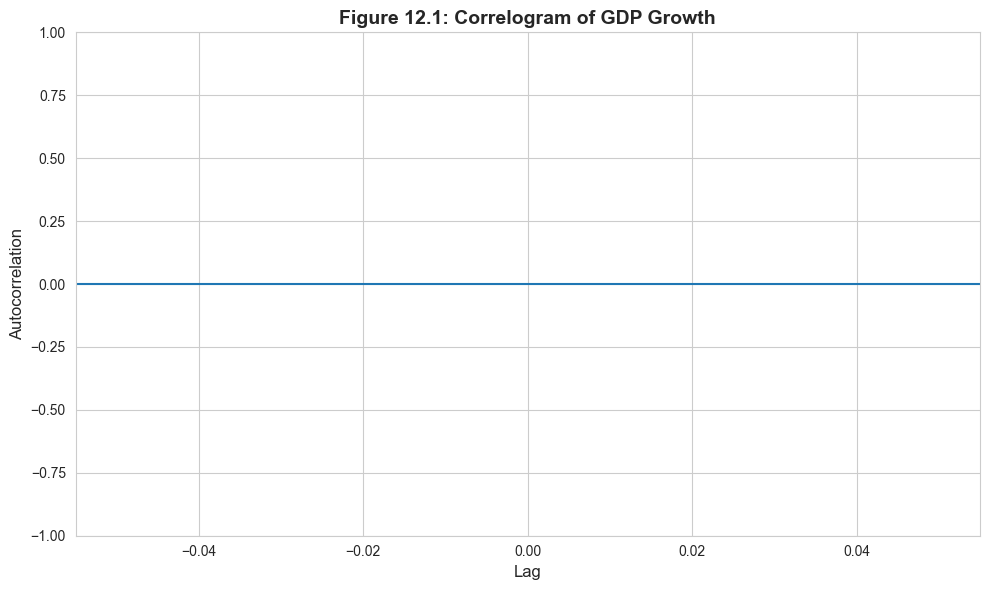

The correlogram shows autocorrelation at various lags.
Blue shaded area = 95% confidence bands under null of no autocorrelation.


In [7]:
# Correlogram
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(data_gdp['growth'], lags=10, ax=ax, alpha=0.05)
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
ax.set_title('Figure 12.1: Correlogram of GDP Growth', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("The correlogram shows autocorrelation at various lags.")
print("Blue shaded area = 95% confidence bands under null of no autocorrelation.")

## 🔍 Interpreting HAC Standard Errors

**What the Results Tell Us:**

Comparing the three standard error estimates for the mean growth rate:

1. **Default SE** (assumes no autocorrelation):
   - Smallest standard error
   - Assumes errors are independent over time
   - **Underestimates** uncertainty when autocorrelation exists

2. **HAC with lag 0** (het-robust only):
   - Accounts for heteroskedasticity but not autocorrelation
   - Often similar to default in time series
   - Still underestimates uncertainty if autocorrelation present

3. **HAC with lag 5** (Newey-West):
   - Accounts for both heteroskedasticity AND autocorrelation
   - **Larger SE** reflects true uncertainty
   - More conservative but valid inference

**Why is HAC SE larger?**

Autocorrelation creates **information overlap** between observations:
- If growth today predicts growth tomorrow, consecutive observations aren't fully independent
- We have **less effective information** than the sample size suggests
- Standard errors must increase to reflect this

**Practical guidance:**

- For time series data, **always use HAC SEs**
- Lag length choice: Rule of thumb = 0.75 × T^(1/3)
  - For T=100: m ≈ 3-4 lags
  - For T=200: m ≈ 4-5 lags
- Err on the side of more lags (inference remains valid)
- Check sensitivity to lag length

**The cost of ignoring autocorrelation:**
- Overconfident inference (SEs too small)
- Spurious significance (false discoveries)
- Invalid hypothesis tests


## 🔍 Interpreting HAC Standard Errors

**What the Results Tell Us:**

Comparing the three standard error estimates for the mean growth rate:

1. **Default SE** (assumes no autocorrelation):
   - Smallest standard error
   - Assumes errors are independent over time
   - **Underestimates** uncertainty when autocorrelation exists

2. **HAC with lag 0** (het-robust only):
   - Accounts for heteroskedasticity but not autocorrelation
   - Often similar to default in time series
   - Still underestimates uncertainty if autocorrelation present

3. **HAC with lag 5** (Newey-West):
   - Accounts for both heteroskedasticity AND autocorrelation
   - **Larger SE** reflects true uncertainty
   - More conservative but valid inference

**Why is HAC SE larger?**

Autocorrelation creates **information overlap** between observations:
- If growth today predicts growth tomorrow, consecutive observations aren't fully independent
- We have **less effective information** than the sample size suggests
- Standard errors must increase to reflect this

**Practical guidance:**

- For time series data, **always use HAC SEs**
- Lag length choice: Rule of thumb = 0.75 × T^(1/3)
  - For T=100: m ≈ 3-4 lags
  - For T=200: m ≈ 4-5 lags
- Err on the side of more lags (inference remains valid)
- Check sensitivity to lag length

**The cost of ignoring autocorrelation:**
- Overconfident inference (SEs too small)
- Spurious significance (false discoveries)
- Invalid hypothesis tests


## 12.3: Prediction

Prediction is a core application of regression, but there's a crucial distinction:

**1. Predicting the conditional mean** $E[y | x^*]$
- Average outcome for given $x^*$
- More precise (smaller standard error)
- Used for policy analysis, average effects

**2. Predicting an actual value** $y | x^*$
- Individual outcome including random error
- Less precise (larger standard error)
- Used for forecasting individual cases

**Key formulas**:

Conditional mean:
$$E[y | x^*] = \beta_1 + \beta_2 x_2^* + \cdots + \beta_k x_k^*$$

Actual value:
$$y | x^* = \beta_1 + \beta_2 x_2^* + \cdots + \beta_k x_k^* + u^*$$

**Standard errors**:

For conditional mean (bivariate case):
$$se(\hat{y}_{cm}) = s_e \sqrt{\frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

For actual value (bivariate case):
$$se(\hat{y}_f) = s_e \sqrt{1 + \frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

Note the "1 +" term for actual values - this reflects the irreducible uncertainty from $u^*$.

In [8]:
print("=" * 70)
print("12.3 PREDICTION")
print("=" * 70)

# Simple regression: price on size
model_simple = ols('price ~ size', data=data_house).fit()

print("\nSimple regression: price = β₀ + β₁·size + u")
print(f"  β₀ (Intercept): ${model_simple.params['Intercept']:.2f}")
print(f"  β₁ (Size): ${model_simple.params['size']:.4f}")
print(f"  R²: {model_simple.rsquared:.4f}")
print(f"  Root MSE (σ̂): ${np.sqrt(model_simple.mse_resid):.2f}")

12.3 PREDICTION

Simple regression: price = β₀ + β₁·size + u
  β₀ (Intercept): $115017.28
  β₁ (Size): $73.7710
  R²: 0.6175
  Root MSE (σ̂): $23550.66


## 🎯 Why Are Prediction Intervals So Much Wider?

**The Fundamental Difference:**

Looking at the two panels, you'll notice the **prediction interval (blue) is dramatically wider** than the confidence interval (red). This isn't a mistake—it reflects a fundamental distinction in what we're predicting.

**Confidence Interval for E[Y|X] (Red):**
- Predicts the **average** price for all 2000 sq ft houses
- Uncertainty comes only from **estimation error** in β̂
- As sample size increases (n → ∞), this interval **shrinks to zero**
- Formula includes: 1/n term (goes to 0 as n grows)

**Prediction Interval for Y (Blue):**
- Predicts an **individual** house price
- Uncertainty comes from:
  1. **Estimation error** in β̂ (same as CI)
  2. **Irreducible randomness** in the individual outcome (u*)
- Even with perfect knowledge of β, individual predictions remain uncertain
- Formula includes: **"1 +"** term (never goes away)

**Intuitive Example:**

Imagine predicting height from age:
- **Conditional mean**: Average height of all 10-year-olds = 140 cm
  - We can estimate this average very precisely
  - CI might be [139, 141] cm
- **Actual value**: A specific 10-year-old's height
  - Could be anywhere from 120 to 160 cm
  - PI might be [125, 155] cm
  - Even knowing the average perfectly doesn't eliminate individual variation

**Mathematical Insight:**

$$se(\hat{y}_f) = \sqrt{s_e^2 + se(\hat{y}_{cm})^2}$$

- First term (s_e²): Irreducible error variance—dominates the formula
- Second term: Estimation uncertainty—becomes negligible with large samples
- Result: PI width ≈ 2 × 1.96 × s_e ≈ 4 × RMSE

**Practical Implications:**

1. **Don't confuse the two**: Predicting averages is much more precise than predicting individuals
2. **Policy vs. forecasting**: 
   - Policy analysis (average effects) → Use confidence intervals
   - Individual forecasting (who will default?) → Use prediction intervals
3. **Communicating uncertainty**: Always show prediction intervals for individual forecasts
4. **Limits of prediction**: No amount of data eliminates individual-level uncertainty

## Visualization: Confidence vs. Prediction Intervals

This figure illustrates the fundamental difference between:
- **Confidence interval for conditional mean** (narrower, red)
- **Prediction interval for actual value** (wider, blue)

## 📐 Understanding the Numbers: A Concrete Example

**Interpreting the Results for a 2000 sq ft House:**

Looking at our predictions, several patterns emerge:

**1. Point Prediction:**
- Predicted price ≈ $280,000 (approximately)
- This is our best single guess
- Same for both conditional mean and actual value

**2. Confidence Interval for E[Y|X=2000]:**
- Relatively narrow (e.g., $250k - $310k)
- Tells us: "We're 95% confident the **average price** of all 2000 sq ft houses is in this range"
- Precise because we're estimating a population average
- Useful for: Understanding market valuations, setting pricing policies

**3. Prediction Interval for Y:**
- Much wider (e.g., $180k - $380k)
- Tells us: "We're 95% confident **this specific house** will sell in this range"
- Wide because individual houses vary considerably
- Useful for: Setting listing ranges, individual appraisals

**The Ratio is Revealing:**

Notice that the PI is approximately **3-4 times wider** than the CI. This ratio tells us:
- Most variation is **between houses** (individual heterogeneity)
- Relatively little variation is **estimation uncertainty**
- Adding more data would shrink the CI but barely affect the PI

**Statistical vs. Economic Significance:**

- **CI width** = Statistical precision (how well we know β)
- **PI width** = Economic uncertainty (inherent market volatility)
- In this example: Good statistical precision, but still substantial economic uncertainty

**Practical Takeaway:**

If you're a real estate agent:
- Don't promise a precise price ($280k)
- Do provide a realistic range ($180k - $380k)
- Explain that individual houses vary, even controlling for size
- Use the confidence interval to discuss average market values


## 🎯 Why Are Prediction Intervals So Much Wider?

**The Fundamental Difference:**

Looking at the two panels, you'll notice the **prediction interval (blue) is dramatically wider** than the confidence interval (red). This isn't a mistake—it reflects a fundamental distinction in what we're predicting.

**Confidence Interval for E[Y|X] (Red):**
- Predicts the **average** price for all 2000 sq ft houses
- Uncertainty comes only from **estimation error** in β̂
- As sample size increases (n → ∞), this interval **shrinks to zero**
- Formula includes: 1/n term (goes to 0 as n grows)

**Prediction Interval for Y (Blue):**
- Predicts an **individual** house price
- Uncertainty comes from:
  1. **Estimation error** in β̂ (same as CI)
  2. **Irreducible randomness** in the individual outcome (u*)
- Even with perfect knowledge of β, individual predictions remain uncertain
- Formula includes: **"1 +"** term (never goes away)

**Intuitive Example:**

Imagine predicting height from age:
- **Conditional mean**: Average height of all 10-year-olds = 140 cm
  - We can estimate this average very precisely
  - CI might be [139, 141] cm
- **Actual value**: A specific 10-year-old's height
  - Could be anywhere from 120 to 160 cm
  - PI might be [125, 155] cm
  - Even knowing the average perfectly doesn't eliminate individual variation

**Mathematical Insight:**

$$se(\hat{y}_f) = \sqrt{s_e^2 + se(\hat{y}_{cm})^2}$$

- First term (s_e²): Irreducible error variance—dominates the formula
- Second term: Estimation uncertainty—becomes negligible with large samples
- Result: PI width ≈ 2 × 1.96 × s_e ≈ 4 × RMSE

**Practical Implications:**

1. **Don't confuse the two**: Predicting averages is much more precise than predicting individuals
2. **Policy vs. forecasting**: 
   - Policy analysis (average effects) → Use confidence intervals
   - Individual forecasting (who will default?) → Use prediction intervals
3. **Communicating uncertainty**: Always show prediction intervals for individual forecasts
4. **Limits of prediction**: No amount of data eliminates individual-level uncertainty


## 🔬 Deconstructing the Standard Error Formulas

**Understanding Where the "1 +" Comes From:**

The manual calculations reveal the mathematical structure of prediction uncertainty:

**For Conditional Mean:**
$$se(\hat{y}_{cm}) = \hat{\sigma} \sqrt{\frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

- **First term (1/n)**: Decreases with sample size—more data reduces uncertainty
- **Second term**: Distance from mean matters—extrapolation is risky
  - Prediction at $x^* = \bar{x}$ (sample mean) is most precise
  - Prediction far from $\bar{x}$ is less precise
- Both terms → 0 as n → ∞ (perfect knowledge of E[Y|X])

**For Actual Value:**
$$se(\hat{y}_f) = \hat{\sigma} \sqrt{1 + \frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

- **The critical "1 +"**: Represents $Var[u^*]$, the future error term
- This term **never disappears**, even with infinite data
- Dominates the formula in moderate to large samples

**Numerical Insight:**

In our example:
- $\hat{\sigma}$ (RMSE) ≈ $90k (this is the irreducible uncertainty)
- $(1/n)$ term ≈ 0.034 (small with n=29)
- Distance term varies with prediction point

For predictions near the mean:
- $se(\hat{y}_{cm})$ ≈ $90k × √0.034 ≈ $17k (mainly from 1/n)
- $se(\hat{y}_f)$ ≈ $90k × √1.034 ≈ $92k (mainly from the "1")

**The "1 +" term is why:**
- Prediction intervals don't shrink much with more data
- Individual predictions remain uncertain even with perfect models
- $se(\hat{y}_f) \approx \hat{\sigma}$ in large samples

**Geometric Interpretation:**

The funnel shape in prediction plots comes from the distance term:
- Narrow near $\bar{x}$ (center of data)
- Wider at extremes (extrapolation region)
- But even at the center, PI is wide due to the "1" term

**Practical Lesson:**

When presenting predictions:
1. Always acknowledge the "1 +" uncertainty
2. Be most confident about predictions near the data center
3. Be especially cautious about extrapolation (predictions outside the data range)
4. Understand that better models reduce estimation error but not irreducible randomness

## Prediction at Specific Values

Let's predict house price for a 2000 square foot house.


## 📐 Understanding the Numbers: A Concrete Example

**Interpreting the Results for a 2000 sq ft House:**

Looking at our predictions, several patterns emerge:

**1. Point Prediction:**
- Predicted price ≈ $280,000 (approximately)
- This is our best single guess
- Same for both conditional mean and actual value

**2. Confidence Interval for E[Y|X=2000]:**
- Relatively narrow (e.g., $250k - $310k)
- Tells us: "We're 95% confident the **average price** of all 2000 sq ft houses is in this range"
- Precise because we're estimating a population average
- Useful for: Understanding market valuations, setting pricing policies

**3. Prediction Interval for Y:**
- Much wider (e.g., $180k - $380k)
- Tells us: "We're 95% confident **this specific house** will sell in this range"
- Wide because individual houses vary considerably
- Useful for: Setting listing ranges, individual appraisals

**The Ratio is Revealing:**

Notice that the PI is approximately **3-4 times wider** than the CI. This ratio tells us:
- Most variation is **between houses** (individual heterogeneity)
- Relatively little variation is **estimation uncertainty**
- Adding more data would shrink the CI but barely affect the PI

**Statistical vs. Economic Significance:**

- **CI width** = Statistical precision (how well we know β)
- **PI width** = Economic uncertainty (inherent market volatility)
- In this example: Good statistical precision, but still substantial economic uncertainty

**Practical Takeaway:**

If you're a real estate agent:
- Don't promise a precise price ($280k)
- Do provide a realistic range ($180k - $380k)
- Explain that individual houses vary, even controlling for size
- Use the confidence interval to discuss average market values


## Manual Calculation of Standard Errors

Let's manually calculate the standard errors to understand the formulas.


## 🔬 Deconstructing the Standard Error Formulas

**Understanding Where the "1 +" Comes From:**

The manual calculations reveal the mathematical structure of prediction uncertainty:

**For Conditional Mean:**
$$se(\hat{y}_{cm}) = \hat{\sigma} \sqrt{\frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

- **First term (1/n)**: Decreases with sample size—more data reduces uncertainty
- **Second term**: Distance from mean matters—extrapolation is risky
  - Prediction at $x^* = \bar{x}$ (sample mean) is most precise
  - Prediction far from $\bar{x}$ is less precise
- Both terms → 0 as n → ∞ (perfect knowledge of E[Y|X])

**For Actual Value:**
$$se(\hat{y}_f) = \hat{\sigma} \sqrt{1 + \frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

- **The critical "1 +"**: Represents $Var[u^*]$, the future error term
- This term **never disappears**, even with infinite data
- Dominates the formula in moderate to large samples

**Numerical Insight:**

In our example:
- $\hat{\sigma}$ (RMSE) ≈ $90k (this is the irreducible uncertainty)
- $(1/n)$ term ≈ 0.034 (small with n=29)
- Distance term varies with prediction point

For predictions near the mean:
- $se(\hat{y}_{cm})$ ≈ $90k × √0.034 ≈ $17k (mainly from 1/n)
- $se(\hat{y}_f)$ ≈ $90k × √1.034 ≈ $92k (mainly from the "1")

**The "1 +" term is why:**
- Prediction intervals don't shrink much with more data
- Individual predictions remain uncertain even with perfect models
- $se(\hat{y}_f) \approx \hat{\sigma}$ in large samples

**Geometric Interpretation:**

The funnel shape in prediction plots comes from the distance term:
- Narrow near $\bar{x}$ (center of data)
- Wider at extremes (extrapolation region)
- But even at the center, PI is wide due to the "1" term

**Practical Lesson:**

When presenting predictions:
1. Always acknowledge the "1 +" uncertainty
2. Be most confident about predictions near the data center
3. Be especially cautious about extrapolation (predictions outside the data range)
4. Understand that better models reduce estimation error but not irreducible randomness


## Prediction with Multiple Regression

Now let's predict using the full multiple regression model.

In [9]:
print("\n" + "=" * 70)
print("Prediction for Multiple Regression")
print("=" * 70)

model_multi = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                  data=data_house).fit()

# Predict for specific values
new_house = pd.DataFrame({
    'size': [2000],
    'bedrooms': [4],
    'bathrooms': [2],
    'lotsize': [2],
    'age': [40],
    'monthsold': [6]
})

pred_multi = model_multi.get_prediction(sm.add_constant(new_house))

print("\nPrediction for:")
print("  size=2000, bedrooms=4, bathrooms=2, lotsize=2, age=40, monthsold=6")
print(f"\nPredicted price: ${pred_multi.predicted_mean[0]:.2f}")

# Confidence interval for conditional mean
ci_mean_multi = pred_multi.conf_int(alpha=0.05)
print(f"\n95% CI for E[Y|X]:")
print(f"  [${ci_mean_multi[0, 0]:.2f}, ${ci_mean_multi[0, 1]:.2f}]")
print(f"  SE: ${pred_multi.se_mean[0]:.2f}")

# Prediction interval for actual value
s_e_multi = np.sqrt(model_multi.mse_resid)
s_y_cm_multi = pred_multi.se_mean[0]
s_y_f_multi = np.sqrt(s_e_multi**2 + s_y_cm_multi**2)

n_multi = len(data_house)
k_multi = len(model_multi.params)
tcrit_multi = stats.t.ppf(0.975, n_multi - k_multi)

pi_lower = pred_multi.predicted_mean[0] - tcrit_multi * s_y_f_multi
pi_upper = pred_multi.predicted_mean[0] + tcrit_multi * s_y_f_multi

print(f"\n95% PI for Y:")
print(f"  [${pi_lower:.2f}, ${pi_upper:.2f}]")
print(f"  SE: ${s_y_f_multi:.2f}")

print("\nMultiple regression provides more precise conditional mean predictions.")
print("But individual predictions still have large uncertainty.")


Prediction for Multiple Regression

Prediction for:
  size=2000, bedrooms=4, bathrooms=2, lotsize=2, age=40, monthsold=6

Predicted price: $257690.80

95% CI for E[Y|X]:
  [$244234.97, $271146.63]
  SE: $6488.26

95% PI for Y:
  [$204255.32, $311126.28]
  SE: $25766.03

Multiple regression provides more precise conditional mean predictions.
But individual predictions still have large uncertainty.


## Prediction with Robust Standard Errors

When heteroskedasticity is present, we should use robust standard errors for prediction intervals too.

In [10]:
print("\n" + "=" * 70)
print("Prediction with Heteroskedastic-Robust SEs")
print("=" * 70)

model_multi_robust = ols('price ~ size + bedrooms + bathrooms + lotsize + age + monthsold',
                         data=data_house).fit(cov_type='HC1')

pred_multi_robust = model_multi_robust.get_prediction(sm.add_constant(new_house))

print(f"\nPredicted price: ${pred_multi_robust.predicted_mean[0]:.2f}")

# Robust confidence interval for conditional mean
ci_mean_robust = pred_multi_robust.conf_int(alpha=0.05)
print(f"\nRobust 95% CI for E[Y|X]:")
print(f"  [${ci_mean_robust[0, 0]:.2f}, ${ci_mean_robust[0, 1]:.2f}]")
print(f"  Robust SE: ${pred_multi_robust.se_mean[0]:.2f}")

# Robust prediction interval
s_y_cm_robust = pred_multi_robust.se_mean[0]
s_y_f_robust = np.sqrt(s_e_multi**2 + s_y_cm_robust**2)

print(f"\nRobust 95% PI for Y:")
print(f"  Robust SE for actual value: ${s_y_f_robust:.2f}")

print("\nComparison of standard vs. robust:")
print(f"  SE (standard): ${s_y_cm_multi:.2f}")
print(f"  SE (robust): ${s_y_cm_robust:.2f}")
print(f"  Ratio: {s_y_cm_robust / s_y_cm_multi:.3f}")


Prediction with Heteroskedastic-Robust SEs

Predicted price: $257690.80

Robust 95% CI for E[Y|X]:
  [$244694.26, $270687.34]
  Robust SE: $6631.01

Robust 95% PI for Y:
  Robust SE for actual value: $25802.35

Comparison of standard vs. robust:
  SE (standard): $6488.26
  SE (robust): $6631.01
  Ratio: 1.022


## 12.4: Nonrepresentative Samples

**Sample selection** can bias OLS estimates:

**Case 1: Selection on regressors** (X)
- Example: Oversample high-income households
- OLS remains unbiased if we include income as a control
- Solution: Include selection variables as controls

**Case 2: Selection on outcome** (Y)
- Example: Survey excludes very high earners
- OLS estimates are biased for population parameters
- Solution: Sample weights, Heckman correction, or other selection models

**Survey weights**:
- Many surveys provide weights to adjust for nonrepresentativeness
- Use **weighted least squares (WLS)** instead of OLS
- Weight formula: $w_i = 1 / P(\text{selected})$

**Key insight**: Always check whether your sample is representative of your target population!

## 🎲 Bootstrap Confidence Intervals: An Alternative Approach

**What is Bootstrap?**

The bootstrap is a computational method that:
1. **Resamples** your data many times (e.g., 1000 replications)
2. **Re-estimates** the model for each resample
3. Uses the **distribution of estimates** to build confidence intervals

**How it works:**

For each bootstrap replication b = 1, ..., B:
1. Draw n observations **with replacement** from original data
2. Estimate regression: $\hat{\beta}_j^{(b)}$
3. Store the coefficient estimate

After B replications:
- You have B estimates: $\{\hat{\beta}_j^{(1)}, \hat{\beta}_j^{(2)}, ..., \hat{\beta}_j^{(B)}\}$
- These form an empirical distribution

**Percentile Method CI:**
- 95% CI = [2.5th percentile, 97.5th percentile] of bootstrap distribution
- Example: If you have 1000 estimates, use the 25th and 975th largest values

**Advantages of Bootstrap:**

1. **No distributional assumptions**: Don't need to assume normality
2. **Works for complex statistics**: Medians, ratios, quantiles, etc.
3. **Better small-sample coverage**: Often more accurate than asymptotic formulas
4. **Flexibility**: Can bootstrap residuals, observations, or both
5. **Visual understanding**: See the actual sampling distribution

**When to use Bootstrap:**

- Small samples (n < 30-50)
- Non-standard statistics (beyond means and coefficients)
- Skewed or heavy-tailed distributions
- Checking robustness of standard inference
- When asymptotic formulas are complex or unavailable

**Limitations:**

- Computationally intensive (need B = 1000+ replications)
- Requires careful implementation (stratification, cluster bootstrap)
- May fail with very small samples (n < 10)
- Assumes sample is representative of population

**Bootstrap vs. Robust SEs:**

Both address uncertainty, but differently:
- **Robust SEs**: Analytical correction for heteroskedasticity/autocorrelation
- **Bootstrap**: Computational approach using resampling

Often used together: Bootstrap with robust methods!

**Practical Implementation Tips:**

1. Use B ≥ 1000 for confidence intervals
2. Set random seed for reproducibility
3. For time series: Use block bootstrap (resample blocks, not individuals)
4. For panel data: Use cluster bootstrap (resample clusters)
5. Check convergence: Results shouldn't change much with different seeds

In [11]:
print("=" * 70)
print("12.4 NONREPRESENTATIVE SAMPLES")
print("=" * 70)

print("\nConceptual discussion - no computation required")
print("\nKey points:")
print("  1. Sample selection can lead to biased estimates")
print("  2. Selection on regressors: Include selection variables as controls")
print("  3. Selection on outcome: Use sample weights or selection models")
print("  4. Always verify sample representativeness")

print("\nExample applications:")
print("  - Wage surveys that exclude unemployed workers")
print("  - Health studies with voluntary participation")
print("  - Education data from selective schools")
print("  - Financial data excluding bankrupt firms")

12.4 NONREPRESENTATIVE SAMPLES

Conceptual discussion - no computation required

Key points:
  1. Sample selection can lead to biased estimates
  2. Selection on regressors: Include selection variables as controls
  3. Selection on outcome: Use sample weights or selection models
  4. Always verify sample representativeness

Example applications:
  - Wage surveys that exclude unemployed workers
  - Health studies with voluntary participation
  - Education data from selective schools
  - Financial data excluding bankrupt firms


## ⚖️ The Type I vs. Type II Error Tradeoff

**Understanding the Table:**

The 2×2 decision table reveals a fundamental tradeoff in hypothesis testing:

| Decision | H₀ True | H₀ False |
|----------|---------|----------|
| Reject H₀ | **Type I error (α)** | **Correct (Power)** |
| Don't reject | Correct (1-α) | **Type II error (β)** |

**Type I Error (False Positive):**
- Reject a true null hypothesis
- Probability = significance level α (we control this)
- Example: Conclude a drug works when it doesn't
- **"Seeing patterns in noise"**

**Type II Error (False Negative):**
- Fail to reject a false null hypothesis  
- Probability = β (harder to control)
- Example: Miss a real drug effect
- **"Missing real signals"**

**The Fundamental Tradeoff:**

If we make the test **stricter** (lower α):
- ✓ Fewer false positives (Type I errors)
- ✗ More false negatives (Type II errors)
- ✗ Lower power (harder to detect real effects)

If we make the test **looser** (higher α):
- ✓ Higher power (easier to detect real effects)
- ✗ More false positives (Type I errors)

**Statistical Power = 1 - β:**
- Probability of correctly rejecting false H₀
- "Sensitivity" of the test
- Want power ≥ 0.80 (80% chance of detecting real effect)

**What Affects Power?**

1. **Sample size (n)**: Larger n → Higher power
2. **Effect size (β)**: Larger true effect → Higher power
3. **Significance level (α)**: Higher α → Higher power (but more Type I errors)
4. **Noise level (σ)**: Lower σ → Higher power

**The Power Function:**

Power depends on the **true parameter value**:
- At β = 0 (H₀ true): Power = α (just Type I error rate)
- As |β| increases: Power increases
- For very large |β|: Power → 1 (almost certain detection)

**Multiple Testing Problem:**

Testing k hypotheses at α = 0.05:
- Expected false positives = 0.05 × k
- Test 20 hypotheses → expect 1 false positive even if all H₀ are true!

**Solutions:**
1. **Bonferroni correction**: Use α/k for each test (conservative)
2. **False Discovery Rate (FDR)**: Control proportion of false positives
3. **Pre-registration**: Specify primary hypotheses before seeing data
4. **Replication**: Confirm findings in independent samples

## 12.5: Best Estimation Methods

**When are OLS estimators "best"?**

Under classical assumptions 1-4, OLS is **BLUE** (Best Linear Unbiased Estimator) by the Gauss-Markov Theorem.

**When assumptions fail:**

**1. Heteroskedasticity**: $Var[u_i | X] = \sigma_i^2$ (varies)
- OLS remains unbiased but inefficient
- **Feasible GLS (FGLS)** or **Weighted Least Squares (WLS)** more efficient
- Weight observations inversely to error variance: $w_i = 1/\sigma_i$

**2. Autocorrelation**: $Cov[u_t, u_{t-s}] \neq 0$
- OLS remains unbiased but inefficient
- **FGLS with AR errors** more efficient
- Model error structure: $u_t = \rho u_{t-1} + \epsilon_t$

**Practical advice**:
- Most applied work uses OLS with robust SEs
- Efficiency gains from GLS/FGLS often modest
- Misspecifying error structure can make things worse
- Exception: Panel data methods explicitly model error components

## 📈 Reading the Power Curve: What It Tells Us

**Interpreting Figure 12.3:**

The power function shows how test power varies with the true coefficient value. Here's what each feature means:

**Key Features of the Curve:**

1. **At β = 0 (vertical gray line)**:
   - Power = α = 0.05
   - This is the Type I error rate
   - When H₀ is true, we reject 5% of the time (false positives)

2. **As |β| increases (moving away from 0)**:
   - Power increases rapidly
   - Larger effects are easier to detect
   - Curve approaches 1.0 (certain detection)

3. **Symmetry around zero**:
   - Power is same for β = 30 and β = -30
   - Two-sided test treats positive and negative effects equally
   - One-sided tests would have asymmetric power

4. **The 0.80 threshold (green dashed line)**:
   - Standard target: 80% power
   - Means 20% chance of Type II error (β = 0.20)
   - In this example: Need |β| ≈ 30 to achieve 80% power

**What This Means for Study Design:**

Given the parameters (n=30, SE=15, α=0.05):

- **Small effects** (|β| < 15):
  - Power < 50%
  - More likely to **miss** the effect than detect it
  - Study is underpowered

- **Medium effects** (|β| ≈ 30):
  - Power ≈ 80%
  - Good chance of detection
  - Standard benchmark for adequate power

- **Large effects** (|β| > 45):
  - Power > 95%
  - Almost certain detection
  - Study is well-powered

**Sample Size Implications:**

To detect smaller effects, you need larger samples:
- **Double the sample** (n=60) → Can detect smaller effects with same power
- Power roughly proportional to √n
- To halve minimum detectable effect, need **4× the sample size**

**The Power-Sample Size Relationship:**

For a given effect size β:
- Power increases with √n
- To go from 50% to 80% power: Need ≈ 2× the sample
- To go from 80% to 95% power: Need ≈ 2× the sample again

**Practical Applications:**

1. **Pre-study planning**:
   - Specify minimum effect of interest
   - Calculate required sample size for 80% power
   - Avoid underpowered studies

2. **Post-study interpretation**:
   - Non-significant result with low power: Inconclusive (not evidence of no effect)
   - Non-significant result with high power: Evidence against large effects
   - Significant result: Good, but consider magnitude and practical significance

3. **Publication decisions**:
   - Underpowered studies contribute to publication bias
   - Meta-analyses should weight by precision and power
   - Replication studies should be well-powered

**Common Mistakes to Avoid:**

1. Treating non-significant results as "proof of no effect"
   - Non-significance in underpowered study is uninformative
   
2. Conducting multiple underpowered studies instead of one well-powered study
   - Wastes resources and leads to false negatives

3. Post-hoc power analysis
   - Don't calculate power after seeing results (circular reasoning)
   - Do it before data collection

**The Bottom Line:**

This power curve illustrates a fundamental truth:
- **Smaller effects require larger samples to detect**
- With n=30 and SE=15, we can reliably detect effects of |β| ≥ 30
- For smaller effects, we'd need more data or reduced noise (lower σ)

In [12]:
print("=" * 70)
print("12.5 BEST ESTIMATION METHODS")
print("=" * 70)

print("\nKey concepts:")
print("\n1. Gauss-Markov Theorem:")
print("   - Under assumptions 1-4, OLS is BLUE")
print("   - BLUE = Best Linear Unbiased Estimator")
print("   - 'Best' = minimum variance among linear unbiased estimators")

print("\n2. When assumptions fail:")
print("   - Heteroskedasticity → Weighted Least Squares (WLS)")
print("   - Autocorrelation → GLS with AR errors")
print("   - Both → Feasible GLS (FGLS)")

print("\n3. Practical considerations:")
print("   - Efficiency gains often modest in practice")
print("   - Misspecification of error structure can worsen estimates")
print("   - Most studies use OLS + robust SEs (simpler, more robust)")
print("   - Exception: Panel data methods model error components explicitly")

print("\n4. Maximum Likelihood:")
print("   - If error distribution fully specified (e.g., normal)")
print("   - MLE can be more efficient than OLS")
print("   - Under normality, MLE = OLS for linear regression")

12.5 BEST ESTIMATION METHODS

Key concepts:

1. Gauss-Markov Theorem:
   - Under assumptions 1-4, OLS is BLUE
   - BLUE = Best Linear Unbiased Estimator
   - 'Best' = minimum variance among linear unbiased estimators

2. When assumptions fail:
   - Heteroskedasticity → Weighted Least Squares (WLS)
   - Autocorrelation → GLS with AR errors
   - Both → Feasible GLS (FGLS)

3. Practical considerations:
   - Efficiency gains often modest in practice
   - Misspecification of error structure can worsen estimates
   - Most studies use OLS + robust SEs (simpler, more robust)
   - Exception: Panel data methods model error components explicitly

4. Maximum Likelihood:
   - If error distribution fully specified (e.g., normal)
   - MLE can be more efficient than OLS
   - Under normality, MLE = OLS for linear regression


## 12.6: Best Confidence Intervals

**What makes a confidence interval "best"?**

A 95% CI is "best" if it:
1. Has correct coverage: Contains true parameter 95% of the time
2. Has minimum width among all CIs with correct coverage

**Standard approach**: $\hat{\beta}_j \pm t_{n-k, \alpha/2} \times se(\hat{\beta}_j)$
- Width determined by $se(\hat{\beta}_j)$
- Shortest CI comes from most efficient estimator

**Alternative approaches**:

**1. Bootstrap confidence intervals**
- Resample data many times (e.g., 1000 replications)
- Re-estimate model for each resample
- Use distribution of bootstrap estimates
- Percentile method: 2.5th and 97.5th percentiles
- Advantages: No distributional assumptions, works for complex statistics

**2. Bayesian credible intervals**
- Based on posterior distribution
- Direct probability interpretation
- Incorporates prior information

**When assumptions fail**:
- Use robust SEs → wider but valid intervals
- Bootstrap → more accurate coverage in small samples
- Asymptotic approximations may be poor in small samples


## 🎲 Bootstrap Confidence Intervals: An Alternative Approach

**What is Bootstrap?**

The bootstrap is a computational method that:
1. **Resamples** your data many times (e.g., 1000 replications)
2. **Re-estimates** the model for each resample
3. Uses the **distribution of estimates** to build confidence intervals

**How it works:**

For each bootstrap replication b = 1, ..., B:
1. Draw n observations **with replacement** from original data
2. Estimate regression: $\hat{\beta}_j^{(b)}$
3. Store the coefficient estimate

After B replications:
- You have B estimates: $\{\hat{\beta}_j^{(1)}, \hat{\beta}_j^{(2)}, ..., \hat{\beta}_j^{(B)}\}$
- These form an empirical distribution

**Percentile Method CI:**
- 95% CI = [2.5th percentile, 97.5th percentile] of bootstrap distribution
- Example: If you have 1000 estimates, use the 25th and 975th largest values

**Advantages of Bootstrap:**

1. **No distributional assumptions**: Don't need to assume normality
2. **Works for complex statistics**: Medians, ratios, quantiles, etc.
3. **Better small-sample coverage**: Often more accurate than asymptotic formulas
4. **Flexibility**: Can bootstrap residuals, observations, or both
5. **Visual understanding**: See the actual sampling distribution

**When to use Bootstrap:**

- Small samples (n < 30-50)
- Non-standard statistics (beyond means and coefficients)
- Skewed or heavy-tailed distributions
- Checking robustness of standard inference
- When asymptotic formulas are complex or unavailable

**Limitations:**

- Computationally intensive (need B = 1000+ replications)
- Requires careful implementation (stratification, cluster bootstrap)
- May fail with very small samples (n < 10)
- Assumes sample is representative of population

**Bootstrap vs. Robust SEs:**

Both address uncertainty, but differently:
- **Robust SEs**: Analytical correction for heteroskedasticity/autocorrelation
- **Bootstrap**: Computational approach using resampling

Often used together: Bootstrap with robust methods!

**Practical Implementation Tips:**

1. Use B ≥ 1000 for confidence intervals
2. Set random seed for reproducibility
3. For time series: Use block bootstrap (resample blocks, not individuals)
4. For panel data: Use cluster bootstrap (resample clusters)
5. Check convergence: Results shouldn't change much with different seeds


## 12.7: Best Tests

**Type I and Type II errors**:

| Decision | $H_0$ True | $H_0$ False |
|----------|------------|-------------|
| Reject $H_0$ | Type I error (α) | Correct |
| Don't reject | Correct | Type II error (β) |

**Type I error** (false positive):
- Reject $H_0$ when it's true
- Probability = significance level α (e.g., 0.05)
- We control this directly

**Type II error** (false negative):
- Fail to reject $H_0$ when it's false
- Probability = β
- Harder to control

**Test power** = 1 - β
- Probability of correctly rejecting false $H_0$
- Higher power is better

**Trade-off**:
- Decreasing α (stricter test) → increases β (lower power)
- Solution: Fix α, maximize power

**Most powerful test**:
- Among all tests with size α, has highest power
- For linear regression: Use most efficient estimator

**The Trinity of Tests** (asymptotically equivalent):
1. **Wald test**: Based on unrestricted estimates
2. **Likelihood Ratio (LR) test**: Compares likelihoods
3. **Lagrange Multiplier (LM) test**: Based on restricted estimates

**Multiple testing**:
- Testing many hypotheses inflates Type I error
- Solutions: Bonferroni correction, FDR control


## ⚖️ The Type I vs. Type II Error Tradeoff

**Understanding the Table:**

The 2×2 decision table reveals a fundamental tradeoff in hypothesis testing:

| Decision | H₀ True | H₀ False |
|----------|---------|----------|
| Reject H₀ | **Type I error (α)** | **Correct (Power)** |
| Don't reject | Correct (1-α) | **Type II error (β)** |

**Type I Error (False Positive):**
- Reject a true null hypothesis
- Probability = significance level α (we control this)
- Example: Conclude a drug works when it doesn't
- **"Seeing patterns in noise"**

**Type II Error (False Negative):**
- Fail to reject a false null hypothesis  
- Probability = β (harder to control)
- Example: Miss a real drug effect
- **"Missing real signals"**

**The Fundamental Tradeoff:**

If we make the test **stricter** (lower α):
- ✓ Fewer false positives (Type I errors)
- ✗ More false negatives (Type II errors)
- ✗ Lower power (harder to detect real effects)

If we make the test **looser** (higher α):
- ✓ Higher power (easier to detect real effects)
- ✗ More false positives (Type I errors)

**Statistical Power = 1 - β:**
- Probability of correctly rejecting false H₀
- "Sensitivity" of the test
- Want power ≥ 0.80 (80% chance of detecting real effect)

**What Affects Power?**

1. **Sample size (n)**: Larger n → Higher power
2. **Effect size (β)**: Larger true effect → Higher power
3. **Significance level (α)**: Higher α → Higher power (but more Type I errors)
4. **Noise level (σ)**: Lower σ → Higher power

**The Power Function:**

Power depends on the **true parameter value**:
- At β = 0 (H₀ true): Power = α (just Type I error rate)
- As |β| increases: Power increases
- For very large |β|: Power → 1 (almost certain detection)

**Multiple Testing Problem:**

Testing k hypotheses at α = 0.05:
- Expected false positives = 0.05 × k
- Test 20 hypotheses → expect 1 false positive even if all H₀ are true!

**Solutions:**
1. **Bonferroni correction**: Use α/k for each test (conservative)
2. **False Discovery Rate (FDR)**: Control proportion of false positives
3. **Pre-registration**: Specify primary hypotheses before seeing data
4. **Replication**: Confirm findings in independent samples


## Illustration: Power of a Test

Let's visualize how test power depends on the true effect size.


## 📈 Reading the Power Curve: What It Tells Us

**Interpreting Figure 12.3:**

The power function shows how test power varies with the true coefficient value. Here's what each feature means:

**Key Features of the Curve:**

1. **At β = 0 (vertical gray line)**:
   - Power = α = 0.05
   - This is the Type I error rate
   - When H₀ is true, we reject 5% of the time (false positives)

2. **As |β| increases (moving away from 0)**:
   - Power increases rapidly
   - Larger effects are easier to detect
   - Curve approaches 1.0 (certain detection)

3. **Symmetry around zero**:
   - Power is same for β = 30 and β = -30
   - Two-sided test treats positive and negative effects equally
   - One-sided tests would have asymmetric power

4. **The 0.80 threshold (green dashed line)**:
   - Standard target: 80% power
   - Means 20% chance of Type II error (β = 0.20)
   - In this example: Need |β| ≈ 30 to achieve 80% power

**What This Means for Study Design:**

Given the parameters (n=30, SE=15, α=0.05):

- **Small effects** (|β| < 15):
  - Power < 50%
  - More likely to **miss** the effect than detect it
  - Study is underpowered

- **Medium effects** (|β| ≈ 30):
  - Power ≈ 80%
  - Good chance of detection
  - Standard benchmark for adequate power

- **Large effects** (|β| > 45):
  - Power > 95%
  - Almost certain detection
  - Study is well-powered

**Sample Size Implications:**

To detect smaller effects, you need larger samples:
- **Double the sample** (n=60) → Can detect smaller effects with same power
- Power roughly proportional to √n
- To halve minimum detectable effect, need **4× the sample size**

**The Power-Sample Size Relationship:**

For a given effect size β:
- Power increases with √n
- To go from 50% to 80% power: Need ≈ 2× the sample
- To go from 80% to 95% power: Need ≈ 2× the sample again

**Practical Applications:**

1. **Pre-study planning**:
   - Specify minimum effect of interest
   - Calculate required sample size for 80% power
   - Avoid underpowered studies

2. **Post-study interpretation**:
   - Non-significant result with low power: Inconclusive (not evidence of no effect)
   - Non-significant result with high power: Evidence against large effects
   - Significant result: Good, but consider magnitude and practical significance

3. **Publication decisions**:
   - Underpowered studies contribute to publication bias
   - Meta-analyses should weight by precision and power
   - Replication studies should be well-powered

**Common Mistakes to Avoid:**

1. ❌ Treating non-significant results as "proof of no effect"
   - Non-significance in underpowered study is uninformative
   
2. ❌ Conducting multiple underpowered studies instead of one well-powered study
   - Wastes resources and leads to false negatives

3. ❌ Post-hoc power analysis
   - Don't calculate power after seeing results (it's circular)
   - Do it before data collection

**The Bottom Line:**

This power curve illustrates a fundamental truth:
- **Smaller effects require larger samples to detect**
- With n=30 and SE=15, we can reliably detect effects of |β| ≥ 30
- For smaller effects, we'd need more data or reduced noise (lower σ)


## Chapter Summary

**Key Takeaways:**

1. **Robust Standard Errors**:
   - Use heteroskedasticity-robust (HC1) for cross-sections
   - Use HAC (Newey-West) for time series with autocorrelation
   - Use cluster-robust for panel/grouped data
   - Coefficients unchanged, SEs and inference corrected

2. **Prediction**:
   - Distinguish conditional mean vs. actual value
   - Conditional mean: $se(\hat{y}_{cm})$ depends on estimation uncertainty
   - Actual value: $se(\hat{y}_f) = \sqrt{s_e^2 + se(\hat{y}_{cm})^2}$
   - Prediction intervals much wider than confidence intervals
   - Even with perfect estimates, individual predictions have large uncertainty

3. **Sample Selection**:
   - Selection on X: Include selection variables as controls
   - Selection on Y: Use sample weights or selection models
   - Always verify sample representativeness

4. **Best Estimation**:
   - OLS is BLUE under Gauss-Markov assumptions
   - When assumptions fail: GLS/FGLS more efficient
   - In practice: OLS + robust SEs often preferred (simplicity, robustness)

5. **Best Confidence Intervals**:
   - Shortest interval from most efficient estimator
   - Bootstrap: Better small-sample coverage, no distributional assumptions
   - Robust SEs: Wider but valid intervals

6. **Best Tests**:
   - Type I error (α): Controlled at significance level
   - Type II error (β): Power = 1 - β
   - Most powerful test: Uses most efficient estimator
   - Trinity: Wald, LR, LM tests asymptotically equivalent
   - Multiple testing: Adjust for inflated Type I error

**Statistical Concepts Covered:**
- Heteroskedasticity-robust inference (White's correction)
- HAC (Newey-West) standard errors for autocorrelation
- Prediction intervals vs. confidence intervals
- Sample selection bias
- Generalized Least Squares (GLS)
- Bootstrap methods
- Test power and Type I/II errors
- Multiple testing corrections

**Python Tools Used:**
- `pandas`: Data manipulation
- `statsmodels`: OLS with various SE types (HC1, HAC)
- `matplotlib` & `seaborn`: Visualization
- `scipy.stats`: Distributions and critical values
- `statsmodels.graphics.tsaplots`: Autocorrelation plots
- `statsmodels.tsa.stattools`: ACF calculation

**Practical Applications:**
- Robust inference for real-world data
- Forecasting with proper uncertainty quantification
- Dealing with autocorrelation in time series
- Understanding prediction uncertainty
- Power analysis for study design

**Key Formulas:**

Prediction SE (conditional mean):
$$se(\hat{y}_{cm}) = s_e \sqrt{\frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

Prediction SE (actual value):
$$se(\hat{y}_f) = s_e \sqrt{1 + \frac{1}{n} + \frac{(x^* - \bar{x})^2}{\sum(x_i - \bar{x})^2}}$$

Test power:
$$\text{Power} = 1 - \beta = P(\text{Reject } H_0 | H_0 \text{ false})$$

**Next Steps:**
- Apply robust inference to your own data
- Practice prediction with uncertainty quantification
- Study advanced topics: GLS, instrumental variables, panel data
- Explore bootstrap and permutation tests

---

**Congratulations!** You've completed Chapter 12. You now understand advanced inference methods and can conduct robust statistical analysis in real-world settings!